# CNN Experiments on muvr data

First we need to setup the environment and import all the necessary stuff.

In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2

import shutil
import numpy as np
from os import remove
import cPickle as pkl
from os.path import expanduser, exists
import os
import sys
import logging

# Add the mlp python src director to the import search path
mlp_folder = "../python-analytics"
sys.path.append(os.path.abspath(mlp_folder))
# Now we are able to use all the packages defined in mlp_folder

This time we are not going to generate the data but rather use real world annotated training examples.

In [253]:
from muvr.dataset.acceleration_dataset import CSVAccelerationDataset
from muvr.dataset.labelmappers import generate_exercise_labelmapper

model_name = "arms"
working_directory = "../output/cnn-ex-models"
dataset = CSVAccelerationDataset('datasets/Google Drive Exercises', label_mapper=generate_exercise_labelmapper())

print "Number of training examples:", dataset.num_train_examples
print "Number of test examples:", dataset.num_test_examples
print "Number of features:", dataset.num_features
print "Number of labels:", dataset.num_labels

bench-press :  12
triceps-pushdown :  25
angle-chest-press :  26
triceps-dips :  28
barbell-biceps-curl :  33
lateral-pulldown-straight :  33
dumbbell-shoulder-press :  38
dumbbell-bench-press :  43
lateral-raise :  144
triceps-extension :  151
biceps-curl :  176
Number of training examples: 9566
Number of test examples: 815
Number of features: 1200
Number of labels: 11


At first we want to inspect the class distribution of the training and test examples.

In [241]:
from ipy_table import *
from muvr.visualization.datastats import dataset_statistics
from operator import itemgetter

stats = dataset_statistics(dataset)

make_table(stats)
set_global_style(float_format='%0.0f', align="center")
set_column_style(0, align="left")
set_column_style(2, float_format='%0.2f%%')
set_column_style(4, float_format='%0.2f%%')
set_column_style(6, float_format='%0.2f%%')

,Train,Train %,Test,Test %,Overall,Overall %
bench-press,1840,5.18%,50,1.64%,1890,4.90%
angle-chest-press,1920,5.41%,100,3.28%,2020,5.24%
triceps-dips,2702,7.61%,95,3.12%,2797,7.26%
lateral-pulldown-straight,2610,7.35%,207,6.79%,2817,7.31%
triceps-pushdown,2912,8.20%,66,2.17%,2978,7.73%
dumbbell-shoulder-press,2880,8.11%,152,4.99%,3032,7.87%
barbell-biceps-curl,3246,9.14%,150,4.92%,3396,8.81%
biceps-curl,3273,9.22%,734,24.09%,4007,10.40%
dumbbell-bench-press,4040,11.38%,127,4.17%,4167,10.81%
lateral-raise,4940,13.92%,739,24.25%,5679,14.73%


Let's have a look at the generated data. We will plot some of the examples of the different classes.

Ids of plotted examples: [ 1005  6669 10477]


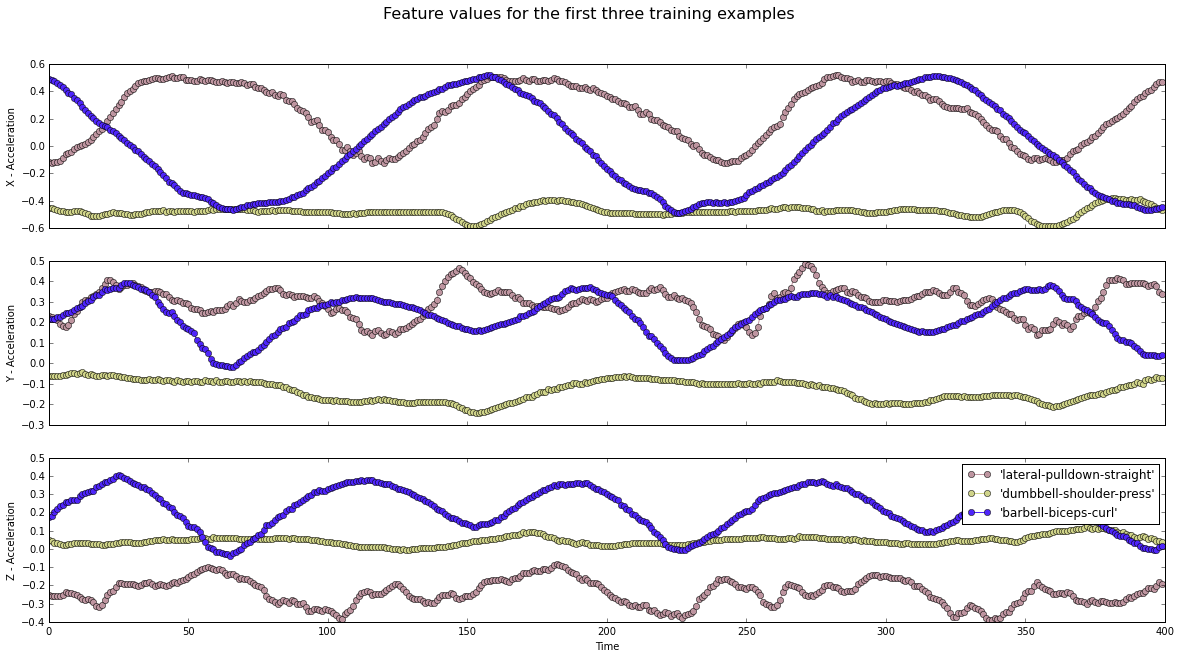

In [190]:
from muvr.visualization.example import plot_examples

# Choose some random examples to plot from the training data
number_of_examples_to_plot = 3
plot_ids = np.random.random_integers(0, dataset.num_train_examples - 1, number_of_examples_to_plot)

print "Ids of plotted examples:",plot_ids

figure = plot_examples(dataset, plot_ids)

Now we are going to create a neon model. We will start with a realy simple one layer preceptron having 500 hidden units.

In [257]:
from muvr.training.trainer import MLPMeasurementModelTrainer
from muvr.training.default_models import generate_default_exercise_model
from neon.layers import *
from neon.models import Model
from neon.transforms import Rectlin, Tanh, Logistic, Softmax
from neon.initializers import Uniform, Gaussian, Constant
    
main_logger = logging.getLogger('neon')
main_logger.setLevel(1)   
    
init_unif = Uniform(low=-0.1,high=0.1)
init_norm = Gaussian(loc=0.0, scale=1.0/20)
bias_init = Constant(val = 1.0)    

layers = []

layers.append(Conv(
    fshape = (5, 1, 16),
    init=init_norm,
    padding={"pad_h" : 2},
    bias=bias_init,
    activation=Rectlin()))

layers.append(Pooling(
    op="max",
    fshape=(2,1),
    strides=2))

layers.append(Conv(
    fshape = (5, 1, 16),
    init=init_norm,
    padding={"pad_h" : 2},
    bias=bias_init,
    activation=Rectlin()))

layers.append(Pooling(
    op="max",
    fshape=(2,1),
    strides=2))

layers.append(Affine(
    nout=50,
    init=init_unif,
    bias=bias_init,
    activation=Rectlin()))

layers.append(Dropout(
    name="do_2",
    keep = 0.9))

layers.append(Affine(
    nout=dataset.num_labels,
    init=init_unif,
    bias=bias_init,
    activation = Softmax()))

mlpmodel = MLPMeasurementModelTrainer(
    working_directory, 
    lrate=0.001,
    max_epochs=25, 
    batch_size=32)

model = mlpmodel.train(dataset, Model(layers=layers))

INFO:neon.backends.nervanacpu:Initialized NervanaCPU
INFO:neon.backends:Backend: cpu, RNG seed: 666
INFO:neon.callbacks.callbacks:Model:
Network Layers:
Sequential
  Convolution Layer 'ConvolutionLayer': 3 x (400x1) inputs, 16 x (400x1) outputs, padding 2, stride 1
  Bias Layer 'BiasLayer': size 16 x (400x1)
  Activation Layer 'ActivationLayer': Rectlin
  Pooling Layer 'PoolingLayer': 16 x (400x1) inputs, 16 x (200x1) outputs
  Convolution Layer 'ConvolutionLayer': 16 x (200x1) inputs, 16 x (200x1) outputs, padding 2, stride 1
  Bias Layer 'BiasLayer': size 16 x (200x1)
  Activation Layer 'ActivationLayer': Rectlin
  Pooling Layer 'PoolingLayer': 16 x (200x1) inputs, 16 x (100x1) outputs
  Linear Layer 'LinearLayer': 1600 inputs, 50 outputs
  Bias Layer 'BiasLayer': size 50
  Activation Layer 'ActivationLayer': Rectlin
  Dropout Layer 'do_2': 50 inputs and outputs, keep 90%
  Linear Layer 'LinearLayer': 50 inputs, 11 outputs
  Bias Layer 'BiasLayer': size 11
  Activation Layer 'Activat

Epochs: 25 Batch-Size: 32
Starting training...
[1200, 'id', 'relu', 'relu', 50, 'relu', 11, 'softmax']
Epoch 0   [Train |████████████████████|  299/299  batches, 2.22 cost, 160.71s] [CrossEntropyMulti Loss 2.14, 4.65s]

INFO:neon.callbacks.callbacks:Epoch 0 complete.  Train Cost 2.343581.  Eval Cost 2.136923



Epoch 1   [Train |████████████████████|  299/299  batches, 0.90 cost, 160.27s] [CrossEntropyMulti Loss 1.32, 5.19s]

INFO:neon.callbacks.callbacks:Epoch 1 complete.  Train Cost 1.600899.  Eval Cost 1.317384



Epoch 2   [Train |████████████████████|  299/299  batches, 0.63 cost, 193.46s] [CrossEntropyMulti Loss 1.25, 7.75s]

INFO:neon.callbacks.callbacks:Epoch 2 complete.  Train Cost 0.922626.  Eval Cost 1.249080



Epoch 3   [Train |████████████████████|  299/299  batches, 0.57 cost, 241.42s] [CrossEntropyMulti Loss 1.21, 7.69s]

INFO:neon.callbacks.callbacks:Epoch 3 complete.  Train Cost 0.787519.  Eval Cost 1.209761



Epoch 4   [Train |████████████████████|  299/299  batches, 0.64 cost, 220.21s] [CrossEntropyMulti Loss 1.17, 7.60s]

INFO:neon.callbacks.callbacks:Epoch 4 complete.  Train Cost 0.681819.  Eval Cost 1.167580



Epoch 5   [Train |████████████████████|  299/299  batches, 0.51 cost, 167.63s] [CrossEntropyMulti Loss 1.15, 4.66s]

INFO:neon.callbacks.callbacks:Epoch 5 complete.  Train Cost 0.584116.  Eval Cost 1.145207



Epoch 6   [Train |████████████████████|  299/299  batches, 0.46 cost, 218.09s] [CrossEntropyMulti Loss 1.10, 7.71s]

INFO:neon.callbacks.callbacks:Epoch 6 complete.  Train Cost 0.510719.  Eval Cost 1.103770



Epoch 7   [Train |████████████████████|  299/299  batches, 0.34 cost, 810.19s] [CrossEntropyMulti Loss 1.13, 4.52s]

INFO:neon.callbacks.callbacks:Epoch 7 complete.  Train Cost 0.455904.  Eval Cost 1.127630



Epoch 8   [Train |████████████████████|  299/299  batches, 0.39 cost, 180.53s] [CrossEntropyMulti Loss 1.09, 7.71s]

INFO:neon.callbacks.callbacks:Epoch 8 complete.  Train Cost 0.414401.  Eval Cost 1.086319



Epoch 9   [Train |████████████████████|  299/299  batches, 0.28 cost, 251.00s] [CrossEntropyMulti Loss 1.13, 8.60s]

INFO:neon.callbacks.callbacks:Epoch 9 complete.  Train Cost 0.388253.  Eval Cost 1.129057



Epoch 10  [Train |████████████████████|  299/299  batches, 0.22 cost, 254.08s] [CrossEntropyMulti Loss 1.15, 5.46s]

INFO:neon.callbacks.callbacks:Epoch 10 complete.  Train Cost 0.358159.  Eval Cost 1.146800



Epoch 11  [Train |████████████████████|  299/299  batches, 0.19 cost, 286.97s] [CrossEntropyMulti Loss 1.15, 9.03s]

INFO:neon.callbacks.callbacks:Epoch 11 complete.  Train Cost 0.338717.  Eval Cost 1.153633



Epoch 12  [Train |                    |   13/299  batches, 0.20 cost, 13.91s]

KeyboardInterrupt: 

To check weather the network is learning something we will plot the weight matrices of the different training epochs.

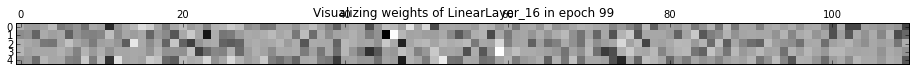

In [236]:
import numpy as np
import math
from matplotlib import pyplot, cm
from pylab import *
import ipywidgets as widgets
from ipywidgets import interact
from ipywidgets import IntSlider
from muvr.util.utils import closest_sqrt

layer_names = map(lambda l: l[1].name+"_"+str(l[0]), filter(lambda l: l[1].has_params, enumerate(model.layers.layers)))
        
def plot_filters(**kwargs):
    n = kwargs['n']
    layer_name = kwargs['layer']
    dest_path = os.path.join(working_directory, 'workout-mlp-ep_' + str(n))
    params = pkl.load(open(dest_path, 'r'))
    
    wts = params['layer_params_states'][layer_names.index(layer_name)]['params']['W']

    nrows, ncols = closest_sqrt(wts.shape[0])
    fr, fc = closest_sqrt(wts.shape[1])
    
    fi = 0

    W = np.zeros((fr*nrows, fc*ncols))
    for row, col in [(row, col) for row in range(nrows) for col in range(ncols)]:
        W[fr*row:fr*(row+1):,fc*col:fc*(col+1)] = wts[fi].reshape(fr,fc)
        fi = fi + 1

    matshow(W, cmap=cm.gray)
    title('Visualizing weights of '+layer_name+' in epoch ' + str(n) )
    show()

_i = interact(plot_filters,
              layer=widgets.widget_selection.ToggleButtons(options = layer_names),
              n=IntSlider(description='epochs',
                                        min=0, max=mlpmodel.max_epochs-1, value=0, step=1))

INFO:neon.models.model:Model weights loaded from ../output/cnn-ex-models/workout-mlp.pkl


Test error = 14.5%
Train error = 12.2%
Minibatches per epoch: 298.96


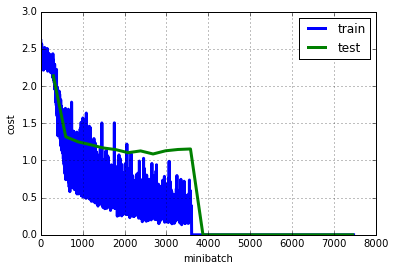

In [258]:
import h5py
from neon.transforms import Misclassification
from matplotlib import pyplot, cm

model = Model(layers=layers)
model.load_weights(mlpmodel.model_path)

logged = h5py.File(os.path.join(working_directory, 'workout-mlp.h5'), "r")
epochs = logged['config'].attrs['total_epochs']
minibatches = logged['config'].attrs['total_minibatches']

print('Test error = %.1f%%'
      % (model.eval(dataset.test(), metric=Misclassification())*100))

print('Train error = %.1f%%'
      % (model.eval(dataset.train(), metric=Misclassification())*100))

print "Minibatches per epoch: %0.2f" % (minibatches * 1.0/epochs)

pyplot.plot(range(0, minibatches), logged['cost/train'], linewidth=3, label='train')
pyplot.plot(range(minibatches / epochs, minibatches, minibatches / epochs ), logged['cost/loss'], linewidth=3, label='test')
pyplot.grid()
pyplot.legend()
pyplot.xlabel("minibatch")
pyplot.ylabel("cost")
pyplot.show()

Let's also have a look at the confusion matrix for the test dataset.

In [259]:
from sklearn.metrics import confusion_matrix
from ipy_table import *
import numpy as np
from muvr.training.prediction import predict

# confusion_matrix(y_true, y_pred)
predicted = predict(model, dataset.test(), dataset.num_labels)

y_true = dataset.y_test
y_pred = np.argmax(predicted, axis = 0) 

confusion_mat = confusion_matrix(y_true, y_pred, range(0,dataset.num_labels))

# Fiddle around with cm to get it into table shape
confusion_mat = np.vstack((np.zeros((1,dataset.num_labels), dtype=int), confusion_mat))
confusion_mat = np.hstack((np.zeros((dataset.num_labels + 1, 1), dtype=int), confusion_mat))

table = confusion_mat.tolist()

human_labels = map(dataset.human_label_for, range(0,dataset.num_labels))

for i,s in enumerate(human_labels):
    table[0][i+1] = s
    table[i+1][0] = s

table[0][0] = "actual \ predicted"
mt = make_table(table)
set_row_style(0, color='lightGray', rotate = "315deg")
set_column_style(0, color='lightGray')
set_global_style(align='center')

for i in range(1, dataset.num_labels + 1):
    for j in range(1, dataset.num_labels + 1):
        if i == j:
            set_cell_style(i,j, color='lightGreen', width = 80)
        elif table[i][j] > 20:
            set_cell_style(i,j, color='Pink')
        elif table[i][j] > 0:
            set_cell_style(i,j, color='lightYellow')
            

mt

actual \ predicted,dumbbell-shoulder-press,dumbbell-bench-press,triceps-pushdown,barbell-biceps-curl,lateral-raise,biceps-curl,triceps-extension,lateral-pulldown-straight,angle-chest-press,triceps-dips,bench-press
dumbbell-shoulder-press,36,4,0,0,0,0,0,0,1,0,0
dumbbell-bench-press,27,8,0,0,0,0,0,0,0,0,0
triceps-pushdown,0,0,17,0,0,0,0,0,0,0,0
barbell-biceps-curl,0,0,0,32,0,8,0,0,0,0,0
lateral-raise,0,0,5,0,187,0,0,3,0,0,0
biceps-curl,0,0,0,8,14,170,0,0,0,6,0
triceps-extension,1,0,0,0,21,5,136,0,4,0,0
lateral-pulldown-straight,0,0,4,0,3,0,0,50,0,0,0
angle-chest-press,3,0,0,0,0,1,0,0,23,0,0
triceps-dips,0,0,0,0,0,0,0,0,0,25,0
